In [1]:
pip install imblearn

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 3.0 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [14]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

## Defining the bucket
s3= boto3.resource('s3')
bucket_name= 'omar-vargas-bucket'
bucket= s3.Bucket(bucket_name)

## Defining the csv file
file_key= 'train.csv'
file_key2= 'test.csv'

bucket_object= bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')
bucket_object2= bucket.Object(file_key2)
file_object2 = bucket_object2.get()
file_content_stream2 = file_object2.get('Body')

## Reading the csv file
train = pd.read_csv(file_content_stream, sep = '|')
test = pd.read_csv(file_content_stream2, sep = '|')
train.head()


,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


In [15]:
## Reporting train observations
len(train)

1879

In [16]:
## Reporting test observations
len(test)

498121

In [17]:
## Frequncy table
train['fraud'].value_counts()

0    1775
1     104
Name: fraud, dtype: int64

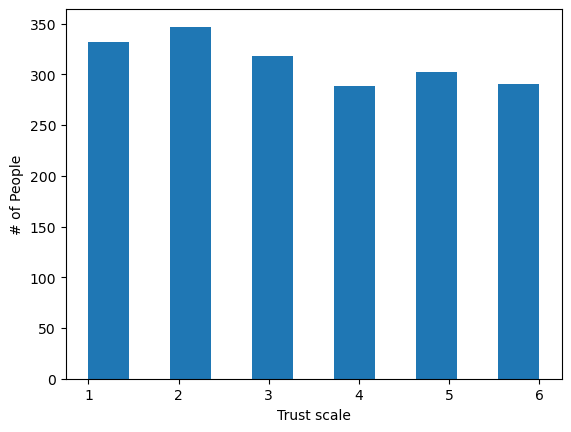

In [38]:
## Plotting trustLevel
plt.hist(train['trustLevel'], bins = 11)
plt.xlabel('Trust scale')
plt.ylabel('# of People')
plt.show();

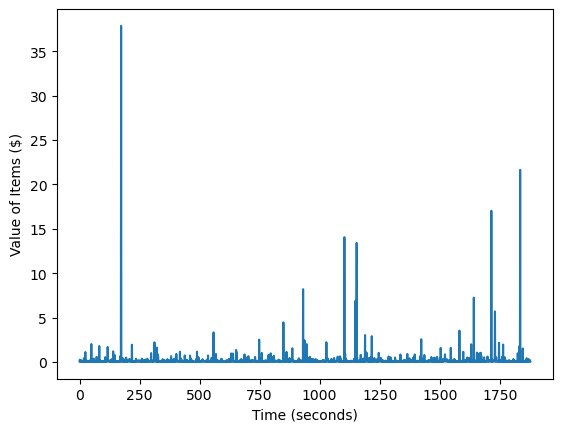

In [32]:
## Plotting valuePerSecond
plt.plot(train['valuePerSecond'])
plt.xlabel('Time (seconds)')
plt.ylabel('Value of Items ($)')
plt.show();

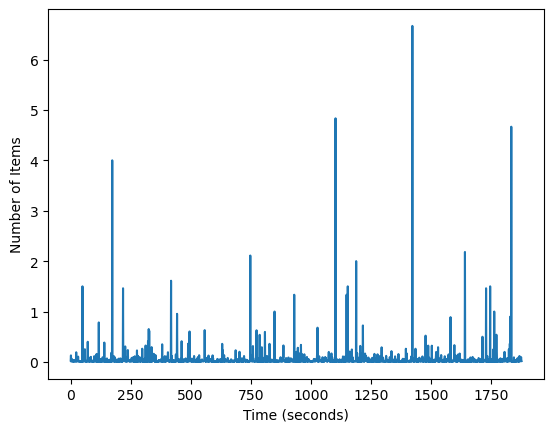

In [30]:
## Plotting scannedLineItemsPerSecond
plt.plot(train['scannedLineItemsPerSecond'])
plt.xlabel('Time (seconds)')
plt.ylabel('Number of Items')
plt.show();

In [40]:
## Defining the input and taregt variables
X= train[['trustLevel', 'scannedLineItemsPerSecond', 'totalScanTimeInSeconds', 'lineItemVoidsPerPosition', 'valuePerSecond']]
Y= train['fraud']

## Splitting the data
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size = .2, stratify = Y)

Model 1: Random Forest

In [43]:
## Building the model
RF_md = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)

## Predicting on the test
RF_pred = RF_md.predict_proba(X_test)[:, 1]

## Precision Recall Curve
precision, recall, threshold = precision_recall_curve(Y_test, RF_pred)

## Finding the optimal threshold, had to take one away from precision and recall as threshold has one less
RF_cutoff= pd.DataFrame({'precision': precision[:-1], 'recall': recall[:-1], 'threshold': threshold})

## Computing the distance to perfect model
RF_cutoff['Distance'] = np.sqrt((1 - RF_cutoff['precision'])**2 + (1 - RF_cutoff['recall'])**2)

## Sorting
RF_cutoff = RF_cutoff.sort_values(by = 'Distance').reset_index(drop = True)

## Changing likelihoods to labels
RF_pred_label = np.where(RF_pred < RF_cutoff['threshold'][0], 0, 1)

## Classification report
print(classification_report(Y_test, RF_pred_label))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       355
           1       0.57      0.81      0.67        21

    accuracy                           0.95       376
   macro avg       0.78      0.89      0.82       376
weighted avg       0.96      0.95      0.96       376



Model 2: AdaBoost

In [44]:
## Building the model
Ada_md = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 3), n_estimators = 500, learning_rate = 0.01).fit(X_train, Y_train)

## Predicting on the test
Ada_pred = RF_md.predict_proba(X_test)[:, 1]

## Precision Recall Curve
precision, recall, threshold = precision_recall_curve(Y_test, Ada_pred)

## Finding the optimal threshold, had to take one away from precision and recall as threshold has one less
Ada_cutoff= pd.DataFrame({'precision': precision[:-1], 'recall': recall[:-1], 'threshold': threshold})

## Computing the distance to perfect model
Ada_cutoff['Distance'] = np.sqrt((1 - Ada_cutoff['precision'])**2 + (1 - Ada_cutoff['recall'])**2)

## Sorting
Ada_cutoff = Ada_cutoff.sort_values(by = 'Distance').reset_index(drop = True)

## Changing likelihoods to labels
Ada_pred_label = np.where(Ada_pred < Ada_cutoff['threshold'][0], 0, 1)

## Classification report
print(classification_report(Y_test, Ada_pred_label))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       355
           1       0.57      0.81      0.67        21

    accuracy                           0.95       376
   macro avg       0.78      0.89      0.82       376
weighted avg       0.96      0.95      0.96       376



In [ ]:
## Based on my results, it would not matter which model I should use to predict Fraud as the scores were the same on everything.